# Prophet

- 페이스북사에서 만든 시계열 예측 모델
- PC에서는 fbprophet을 설치해야 함,  conda install -c conda-forge fbprophet
- 기존에 설치된 다른 라이브러리와 버전 문제가 생기기 쉽다. 이 때는 가상환경 (virtual env)을 하나 만들고 그 가상환경에서 설치하고 실행하면 된다.
- PC에서 설치가 안되면 colab에서 실행한다

## Prophet 장점

- prophet 모델은 현재 값 까지만 알려주고 모든 미래값을 한번에 예측한다
- walk forward 모델이 아니다 (순차적으로 미래 값을 사용하지 않는다)
- 결측치가 있어도 동작한다 (ARIMA 등 수리 모델에서는 결측치가 있으면 오류 발생)
- 세일 기간 등 특별한 이벤트를 모델 자체에 반영할 수 있다 (holiday 지정 기능 사용)

## import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 15})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [8]:
!pip install prophet

In [10]:
#from fbprophet import Prophet
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# 전력사용 예측

In [11]:
power = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/energy_3years.csv",
                 parse_dates=['timestamp'])
power.set_index("timestamp", inplace=True)

print(power.shape)
power[:3]

(26304, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


## 데이터

- 컬럼명을 반드시 ['ds','y']로 지정해야야 함

In [12]:
df = power.resample('D').sum()
df.reset_index(inplace=True)
df.drop('temp', axis=1, inplace=True)
df.columns = ['ds','y']
df

,ds,y
0,2012-01-01,71562.0
1,2012-01-02,76841.0
2,2012-01-03,87887.0
3,2012-01-04,92168.0
4,2012-01-05,88096.0
...,...,...
1091,2014-12-27,73845.0
1092,2014-12-28,74678.0
1093,2014-12-29,84486.0
1094,2014-12-30,88810.0


### 훈련데이터, 검증 데이터 나누기

In [13]:
# 1096개 데이터중 900개를 훈련 데이터로 사용
cut = 900
train_data = df[:cut]  #훈련데이터
test_data = df[cut:]   #검증데이터

## 모델 학습과 예측 수행


### 학습 수행
- 학습에는 train_data 사용

In [14]:
m = Prophet()
m.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp98tnp7n7/7wo2wkf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp98tnp7n7/d60hhe77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35082', 'data', 'file=/tmp/tmp98tnp7n7/7wo2wkf2.json', 'init=/tmp/tmp98tnp7n7/d60hhe77.json', 'output', 'file=/tmp/tmp98tnp7n7/prophet_modellg430xqq/prophet_model-20230921003346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:33:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:33:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### 예측 수행
- 학습 기간을 포함해서 전 구간의 날짜 정보를 준다

In [15]:
all_range = df.copy()
all_range.drop('y', axis=1, inplace=True) #위에서 설정한 자료에서 y값을 뺀다. 그래서 날짜만 남겨둠.
all_range #테스트할때 전 구간을 하는게 좋음. 일부만 보고 싶으면 # plt.xlim([datetime(2014, 1, 1), datetime(2014, 5, 30)]) 이 소스를 이용하면 됨.

,ds
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05
...,...
1091,2014-12-27
1092,2014-12-28
1093,2014-12-29
1094,2014-12-30


- 예측치는 forecast.yhat에 들어 있다 (y_pred)

In [20]:
forecast = m.predict(all_range)  #위에서 날짜만 남긴거에다가  예측치Predic 을 해줌.
forecast[:3]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,75165.005172,71602.274106,81011.470075,75165.005172,75165.005172,1272.981506,1272.981506,1272.981506,-4742.213108,-4742.213108,-4742.213108,6015.194614,6015.194614,6015.194614,0.0,0.0,0.0,76437.986678
1,2012-01-02,75185.655603,77769.871017,87145.688080,75185.655603,75185.655603,7278.732309,7278.732309,7278.732309,1190.475958,1190.475958,1190.475958,6088.256351,6088.256351,6088.256351,0.0,0.0,0.0,82464.387912
2,2012-01-03,75206.306033,78100.869192,87876.463122,75206.306033,75206.306033,7841.414195,7841.414195,7841.414195,1672.795774,1672.795774,1672.795774,6168.618422,6168.618422,6168.618422,0.0,0.0,0.0,83047.720229


## 결과 보기


### 함수 plot() 사용

(16252.0, 16343.0)

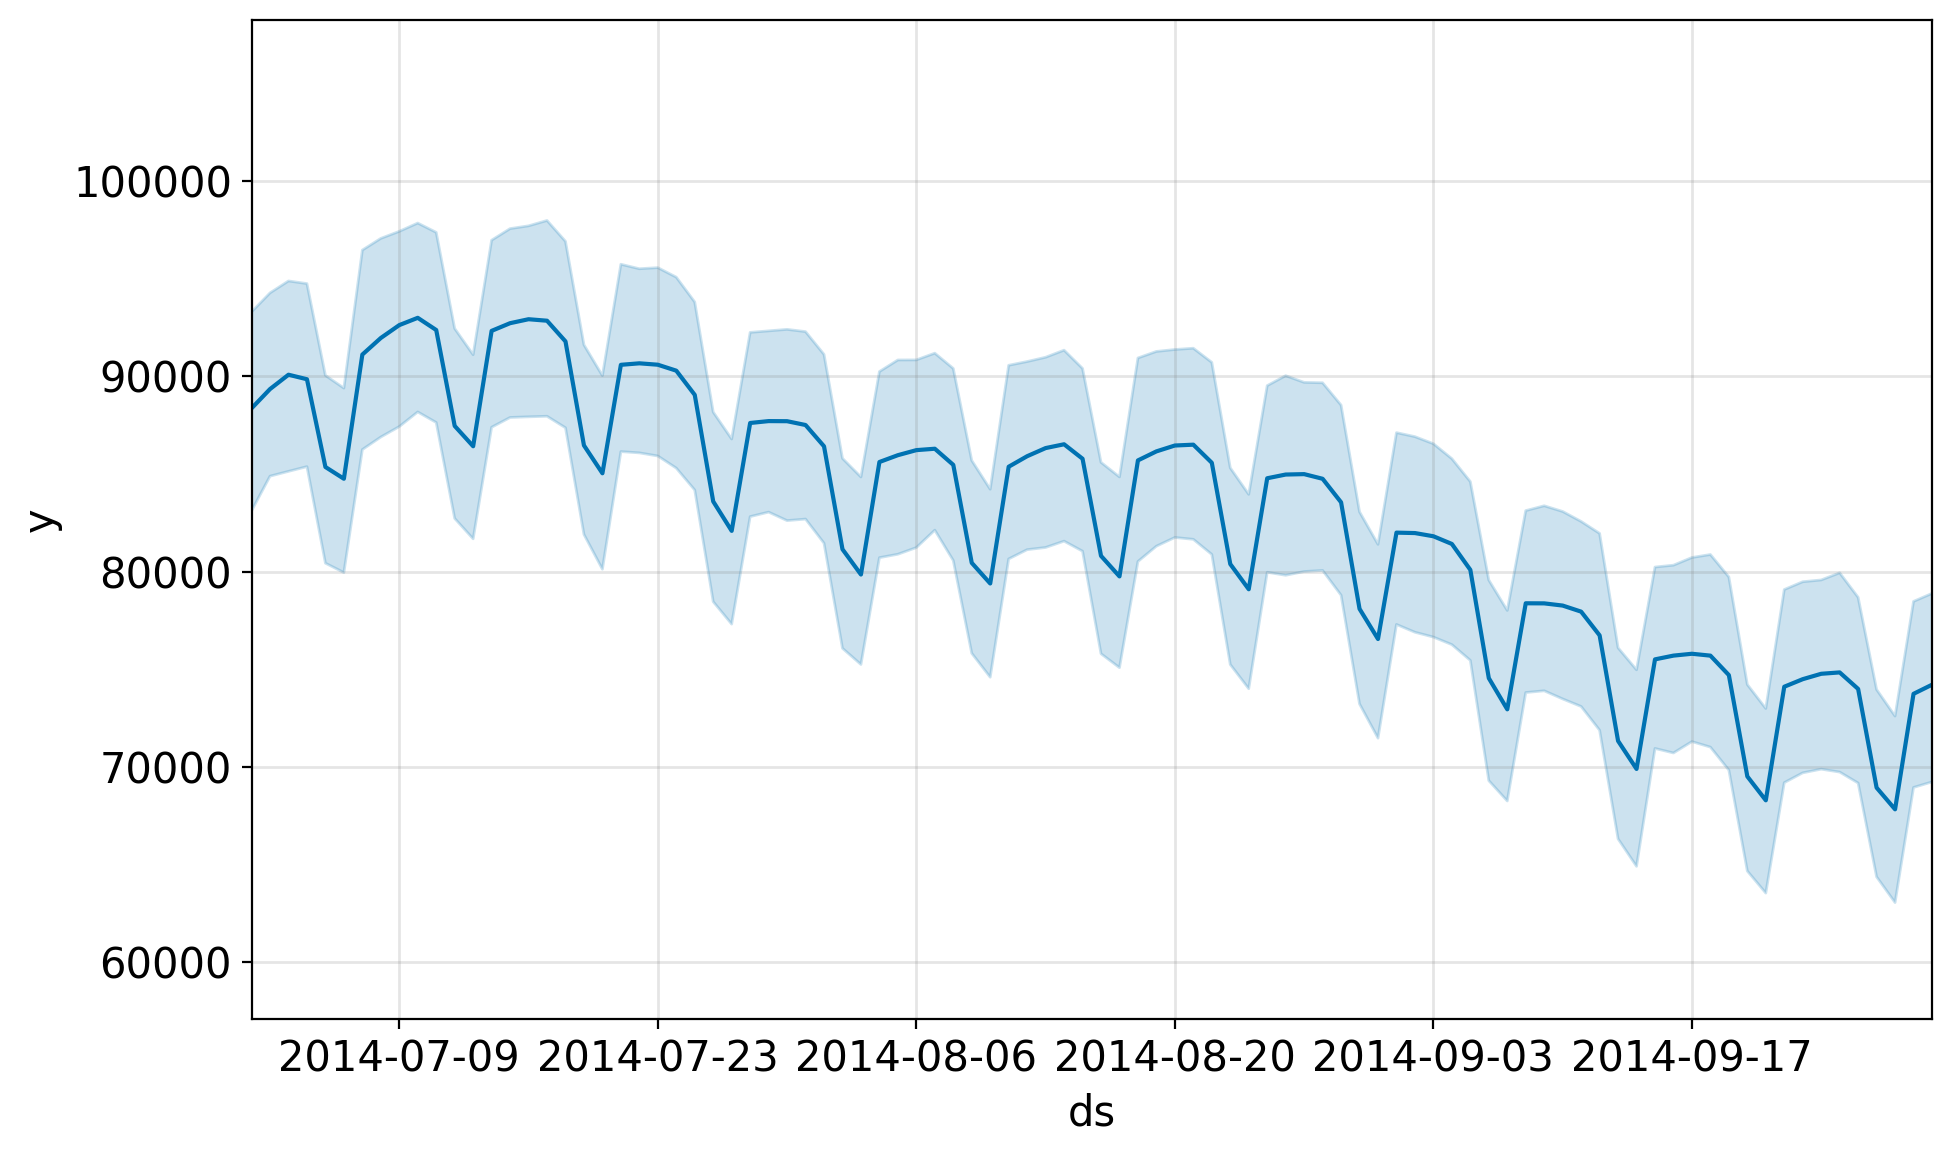

In [33]:
m.plot(forecast)
from datetime import datetime
import matplotlib.pyplot as plt
# 구간 자세히 보기 (아래 해제)
#plt.xlim([datetime(2014, 1, 1), datetime(2014, 5, 30)]) #ALl range가 아닌 일부 구간만 설정하여 자세히 볼 때. 2014.01.01~2014.05.30
plt.xlim([datetime(2014, 7, 1), datetime(2014, 9, 30)])

In [36]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,75165.005172,71602.274106,81011.470075,75165.005172,75165.005172,1272.981506,1272.981506,1272.981506,-4742.213108,-4742.213108,-4742.213108,6015.194614,6015.194614,6015.194614,0.0,0.0,0.0,76437.986678
1,2012-01-02,75185.655603,77769.871017,87145.688080,75185.655603,75185.655603,7278.732309,7278.732309,7278.732309,1190.475958,1190.475958,1190.475958,6088.256351,6088.256351,6088.256351,0.0,0.0,0.0,82464.387912
2,2012-01-03,75206.306033,78100.869192,87876.463122,75206.306033,75206.306033,7841.414195,7841.414195,7841.414195,1672.795774,1672.795774,1672.795774,6168.618422,6168.618422,6168.618422,0.0,0.0,0.0,83047.720229
3,2012-01-04,75226.956464,78566.164471,88014.998044,75226.956464,75226.956464,8281.775060,8281.775060,8281.775060,2025.896144,2025.896144,2025.896144,6255.878916,6255.878916,6255.878916,0.0,0.0,0.0,83508.731524
4,2012-01-05,75247.606894,78781.050913,88435.695377,75247.606894,75247.606894,8506.195562,8506.195562,8506.195562,2156.822955,2156.822955,2156.822955,6349.372606,6349.372606,6349.372606,0.0,0.0,0.0,83753.802456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2014-12-27,78866.523304,76170.747655,86013.622546,77883.957842,79870.452248,2102.326403,2102.326403,2102.326403,-3661.334430,-3661.334430,-3661.334430,5763.660833,5763.660833,5763.660833,0.0,0.0,0.0,80968.849706
1092,2014-12-28,78859.666459,75064.728484,85024.800946,77868.889085,79867.720680,1062.877119,1062.877119,1062.877119,-4742.213108,-4742.213108,-4742.213108,5805.090227,5805.090227,5805.090227,0.0,0.0,0.0,79922.543578
1093,2014-12-29,78852.809614,81085.279029,90794.812444,77853.378142,79865.391352,7042.418898,7042.418898,7042.418898,1190.475958,1190.475958,1190.475958,5851.942940,5851.942940,5851.942940,0.0,0.0,0.0,85895.228511
1094,2014-12-30,78845.952768,81398.148292,91373.410205,77838.110091,79863.062024,7577.919879,7577.919879,7577.919879,1672.795774,1672.795774,1672.795774,5905.124105,5905.124105,5905.124105,0.0,0.0,0.0,86423.872647


### 시계열 컴포넌트 보기

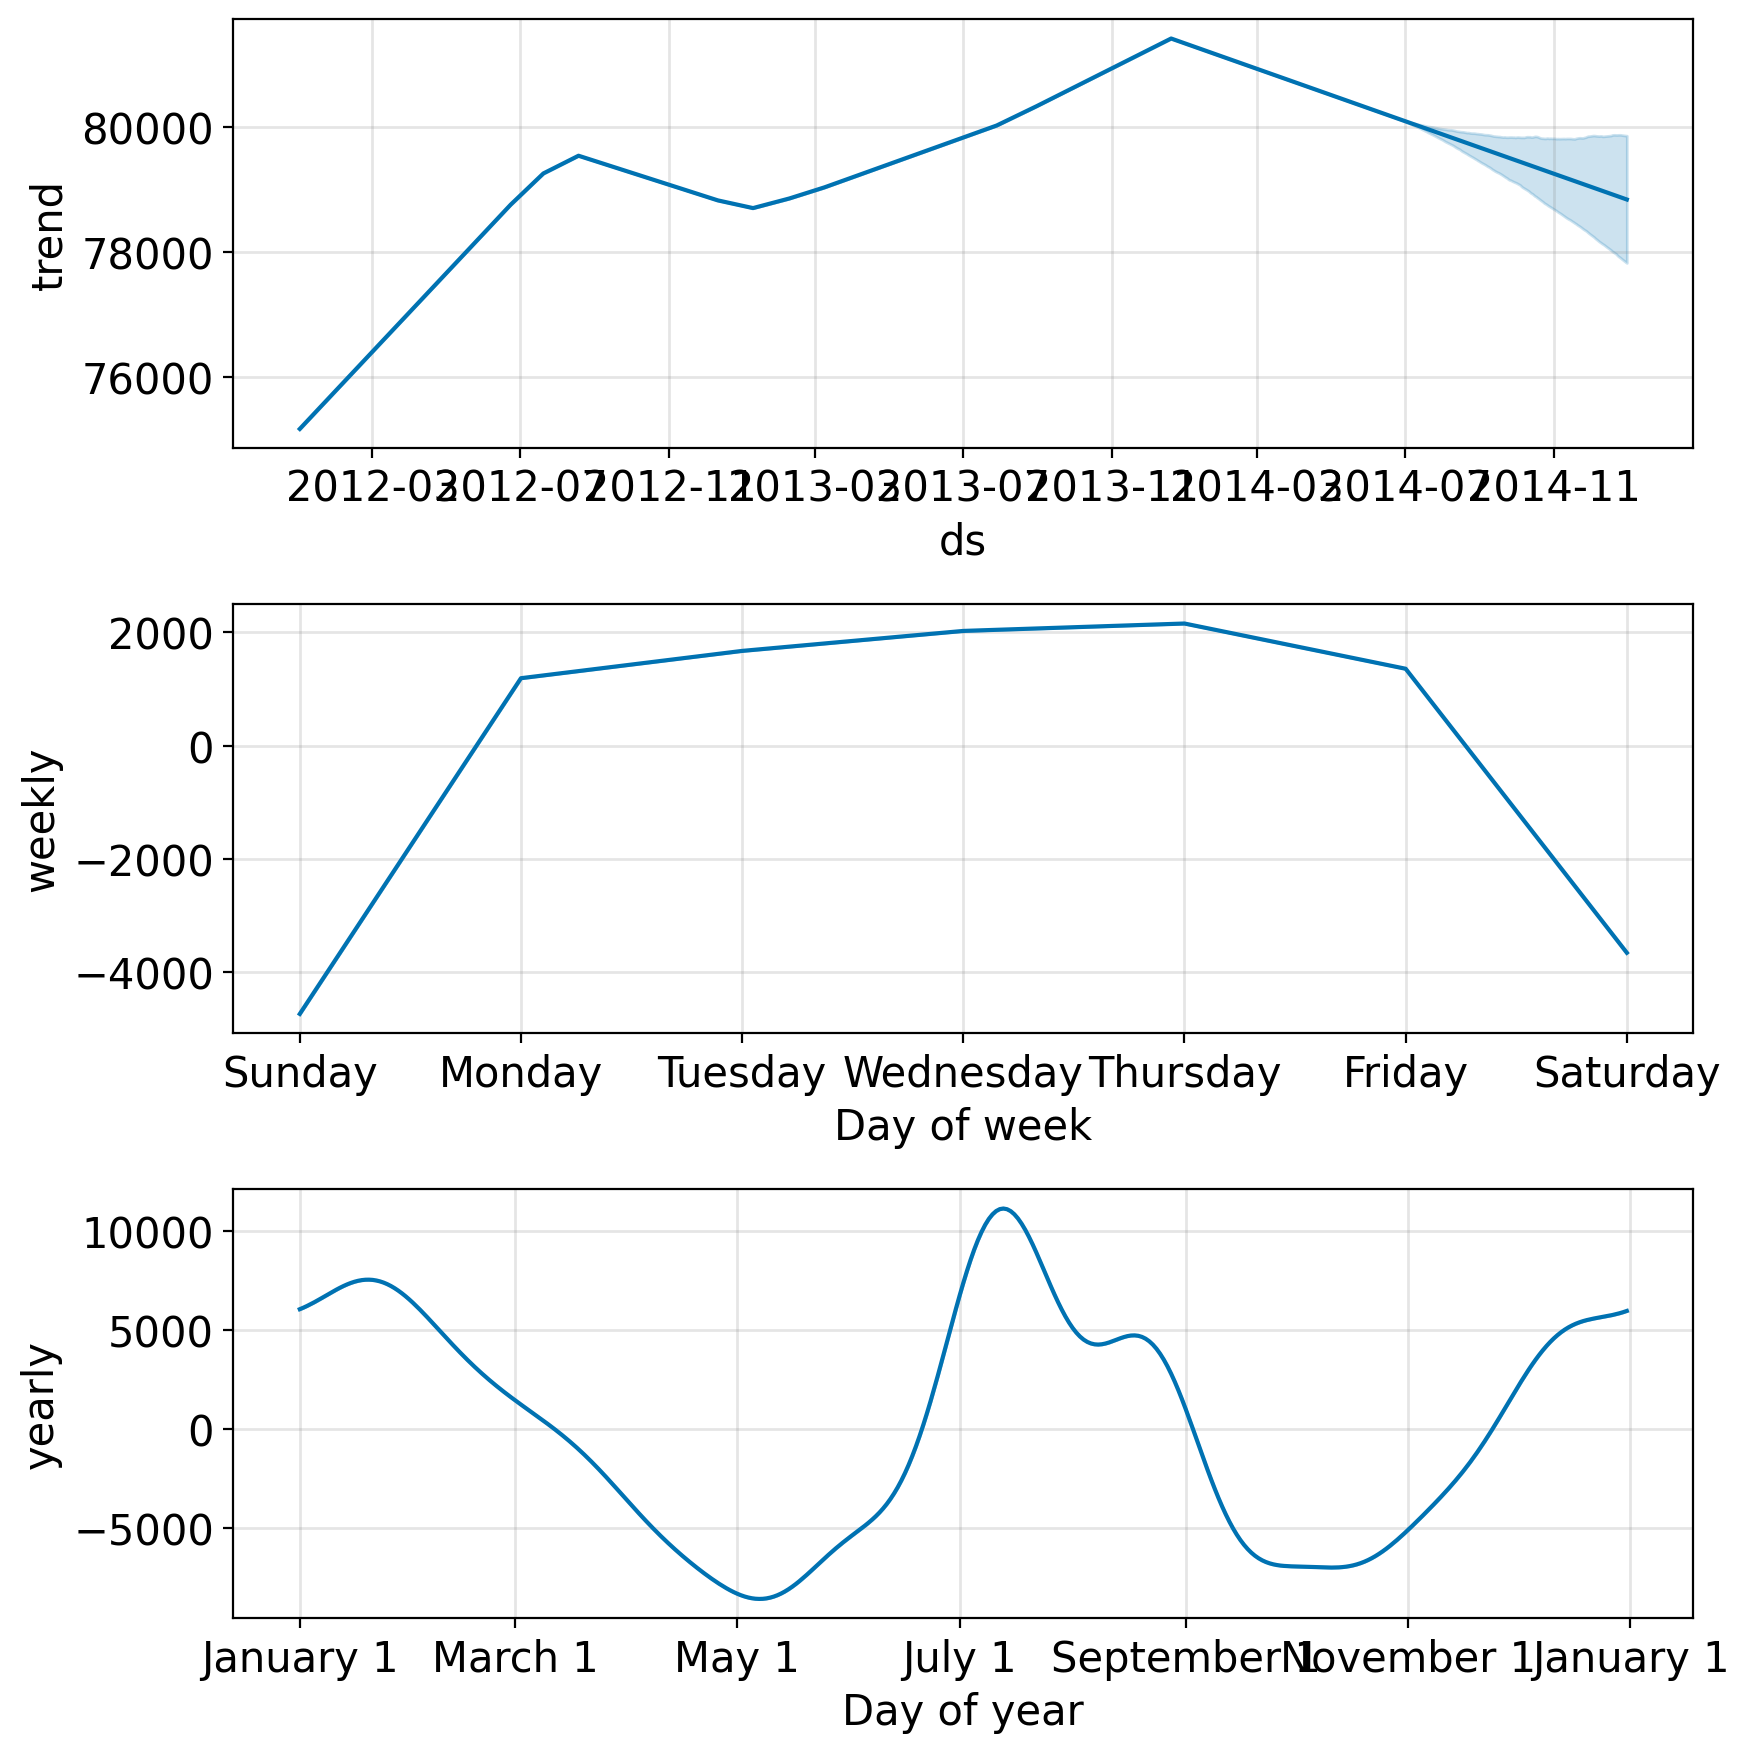

In [24]:
_ = m.plot_components(forecast)

### 결과 성능 평가

In [25]:
y_test = test_data.y
y_test.shape

(196,)

In [26]:
y_pred = forecast[cut:].yhat   #yhat은 예측치가 들어있음.
y_pred.shape

(196,)

In [27]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ",
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ",
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ",
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ",
      r2_score(y_test, y_pred).round(3))

In [28]:
def plot_reg_result(y_test, y_pred, N=50):
    y_t=y_test.ravel()
    y_p=y_pred.ravel()
    plt.plot(y_t[:N], 'r.-', label='y_test')
    plt.plot(y_p[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_t, y_t - y_p, s=5)

In [29]:
show_reg_result(y_test,y_pred)   #성능은 0.446이지만 196일의 미래를 맞춘 것치곤 성능이 나쁘지 않음.

Max Error:  17222.316
Mean Absolute Error:  3685.334
Root Mean Squared Error:  4788.816
R-Squared:  0.446


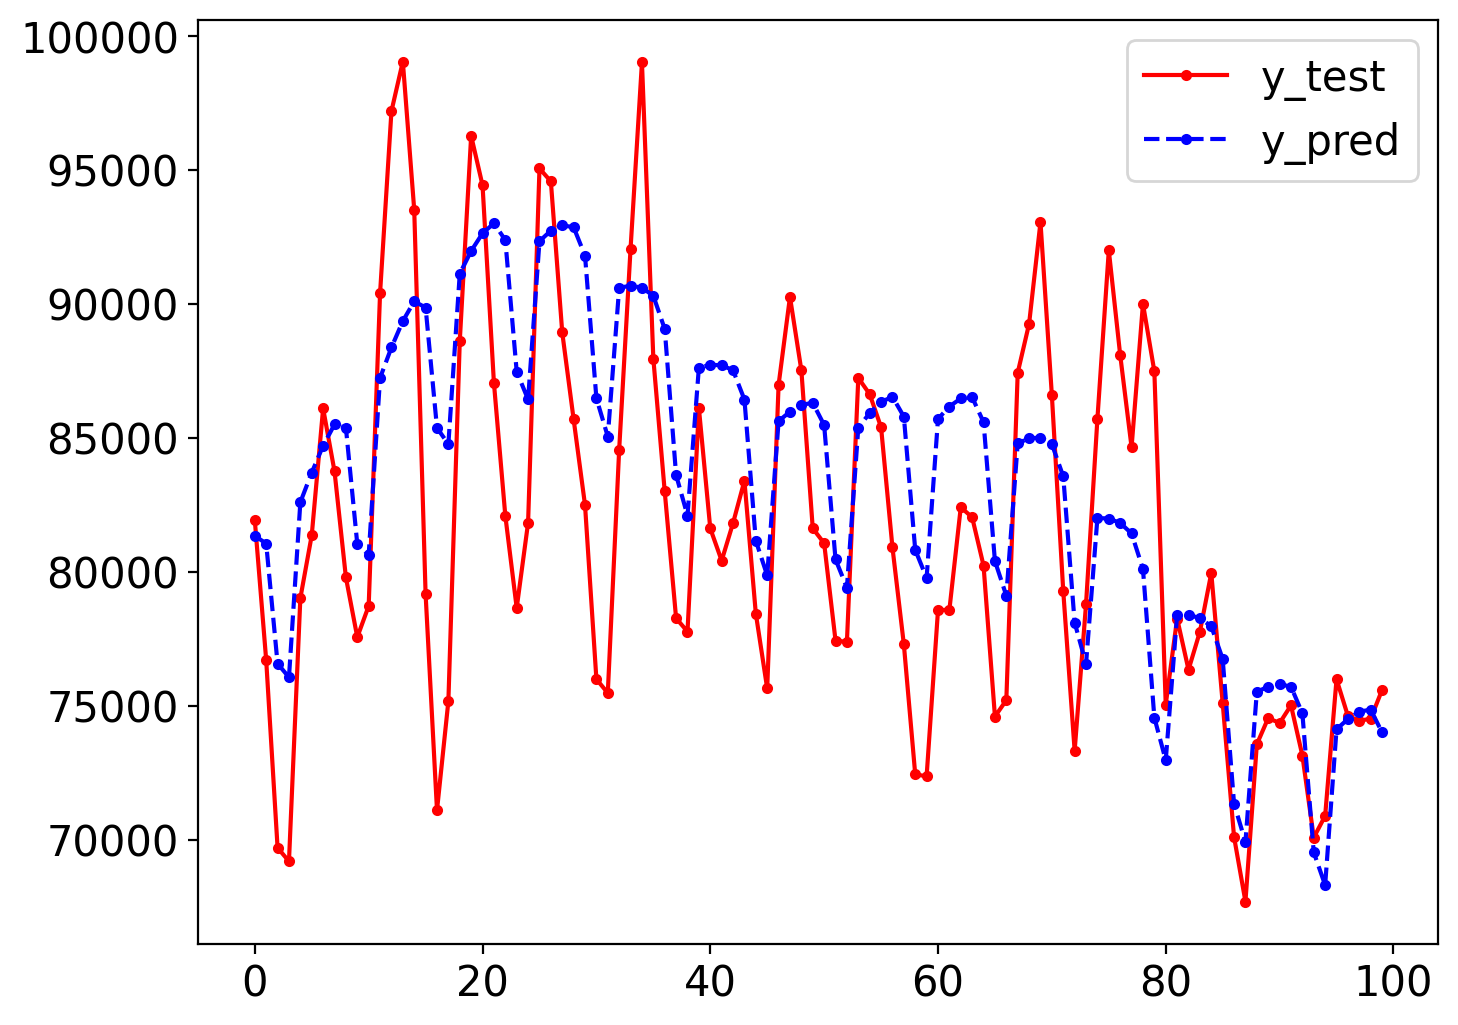

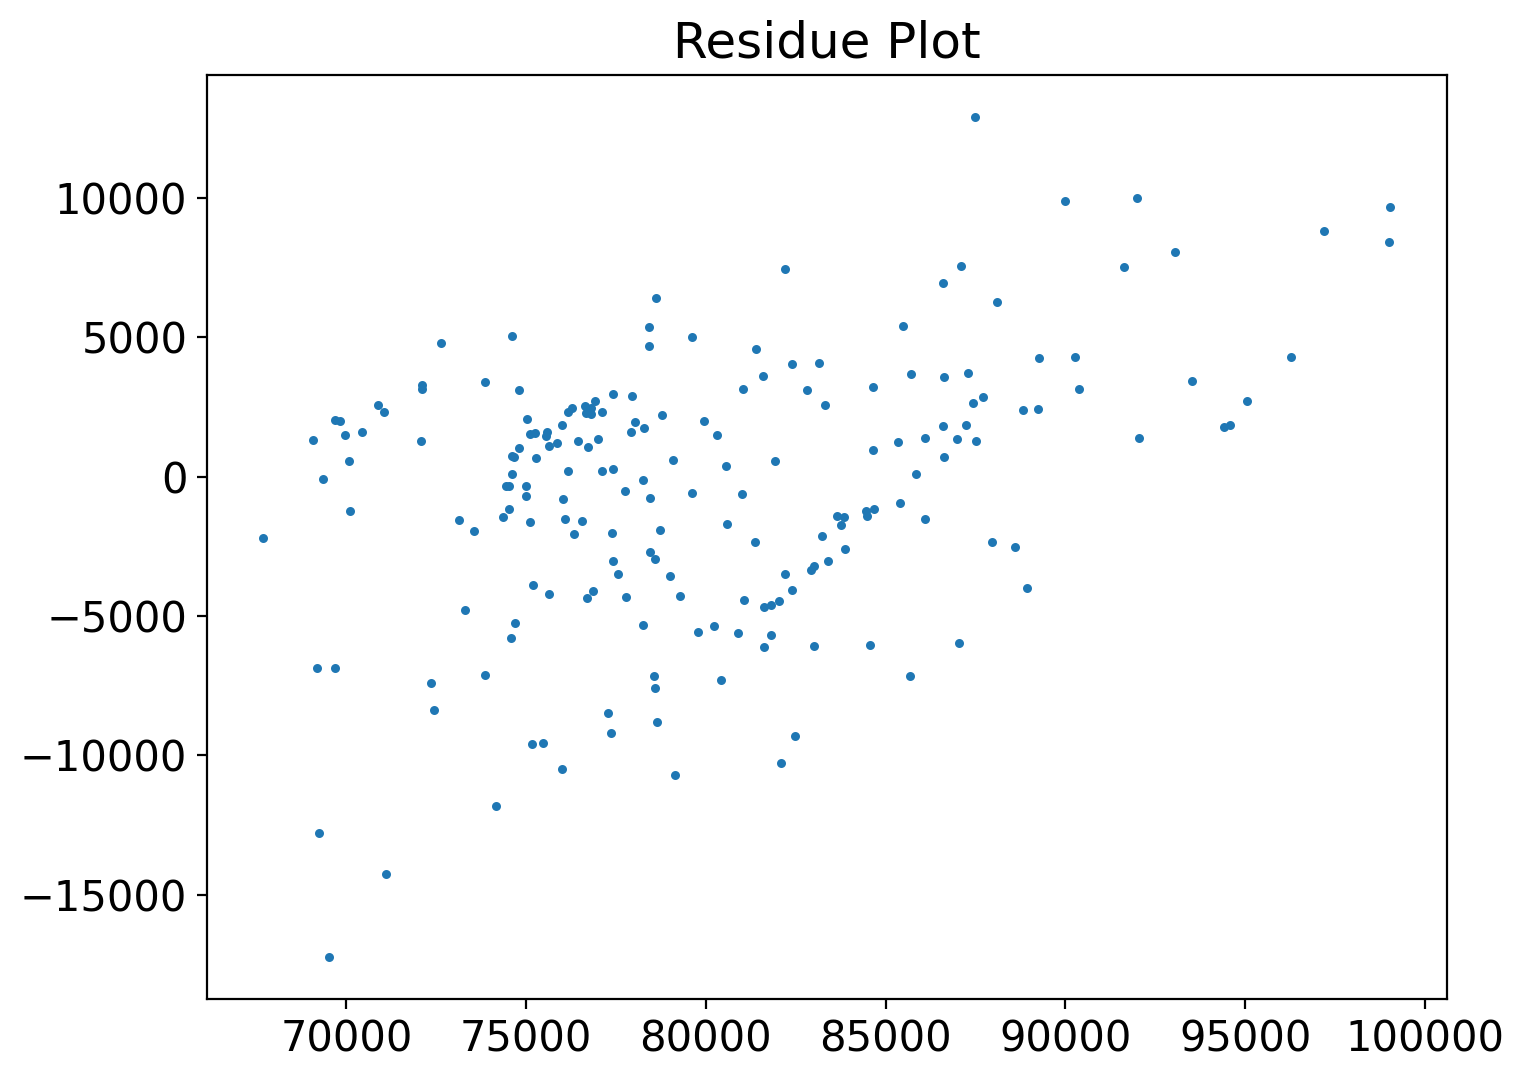

In [30]:
plot_reg_result(y_test, y_pred, 100)  #최소한 빨간색보다는 좋아야함.

## (연습) 훈련 데이터로 950개를 사용하는 모델을 만드시오

In [ ]:
# (풀이)



# 자동차 판매량 예측

## 데이터

In [38]:
path = 'https://raw.githubusercontent.com/StillWork/data/master/car_sales.csv'
car = pd.read_csv(path)
print(car.shape)
car[:3]  #데이터가 100row밖에 없음. 1달에 1번씩 매출이 보여줌. 이를 보여주고, 다음달 Sales 매출을 맞춰봐 .

(108, 2)


,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026


<Axes: >

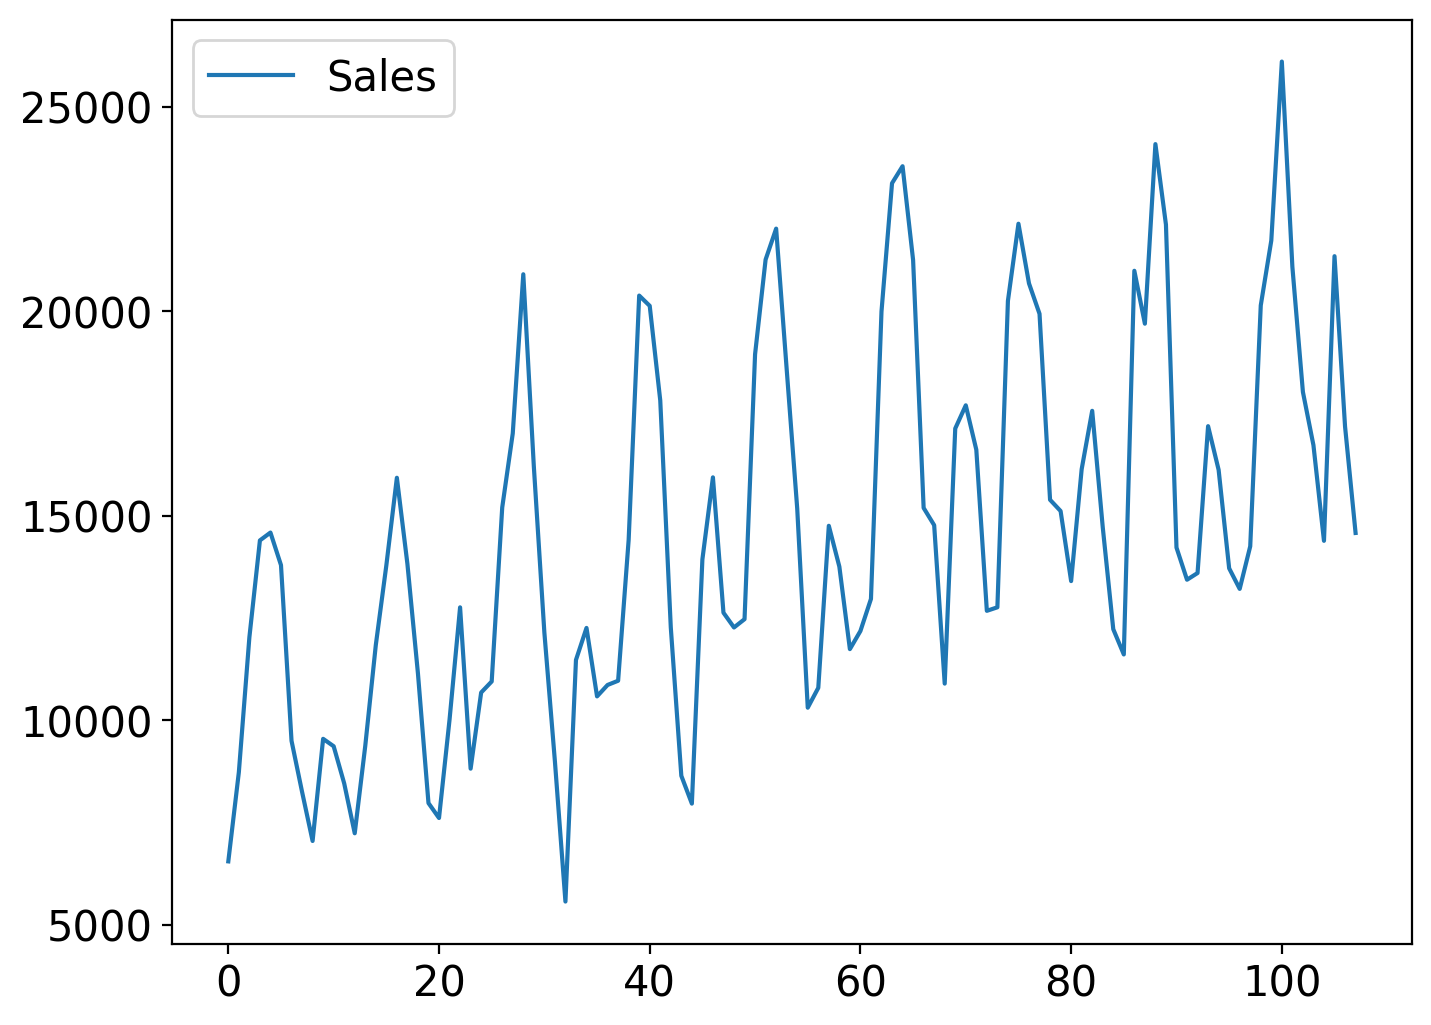

In [39]:
car.plot()

In [40]:
car.columns = ['ds', 'y']
car['ds']= pd.to_datetime(car['ds'])
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      108 non-null    datetime64[ns]
 1   y       108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [41]:
car[:3]

,ds,y
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026


### 훈련과 검증 데이터
- 최종 1년 데이터를 test 데이터로 사용

In [43]:
df = car.copy()
train_data = df[:-12]
test_data = df[-12:] #끝에서 최종 12row를 테스트 데이터로 쓰고 싶음.

## 모델 학습과 예측 수행

In [44]:
all_range = df.drop("y", axis=1)
all_range

,ds
0,1960-01-01
1,1960-02-01
2,1960-03-01
3,1960-04-01
4,1960-05-01
...,...
103,1968-08-01
104,1968-09-01
105,1968-10-01
106,1968-11-01


In [45]:
model = Prophet()
model.fit(train_data)

forecast = model.predict(all_range)
y_pred = forecast[-12:]['yhat'].values
y_test = test_data['y'].values

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp98tnp7n7/r7mrb6os.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp98tnp7n7/iofn_fcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73928', 'data', 'file=/tmp/tmp98tnp7n7/r7mrb6os.json', 'init=/tmp/tmp98tnp7n7/iofn_fcb.json', 'output', 'file=/tmp/tmp98tnp7n7/prophet_model84g6flsn/prophet_model-20230921010827.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:08:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:08:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## 결과 보기

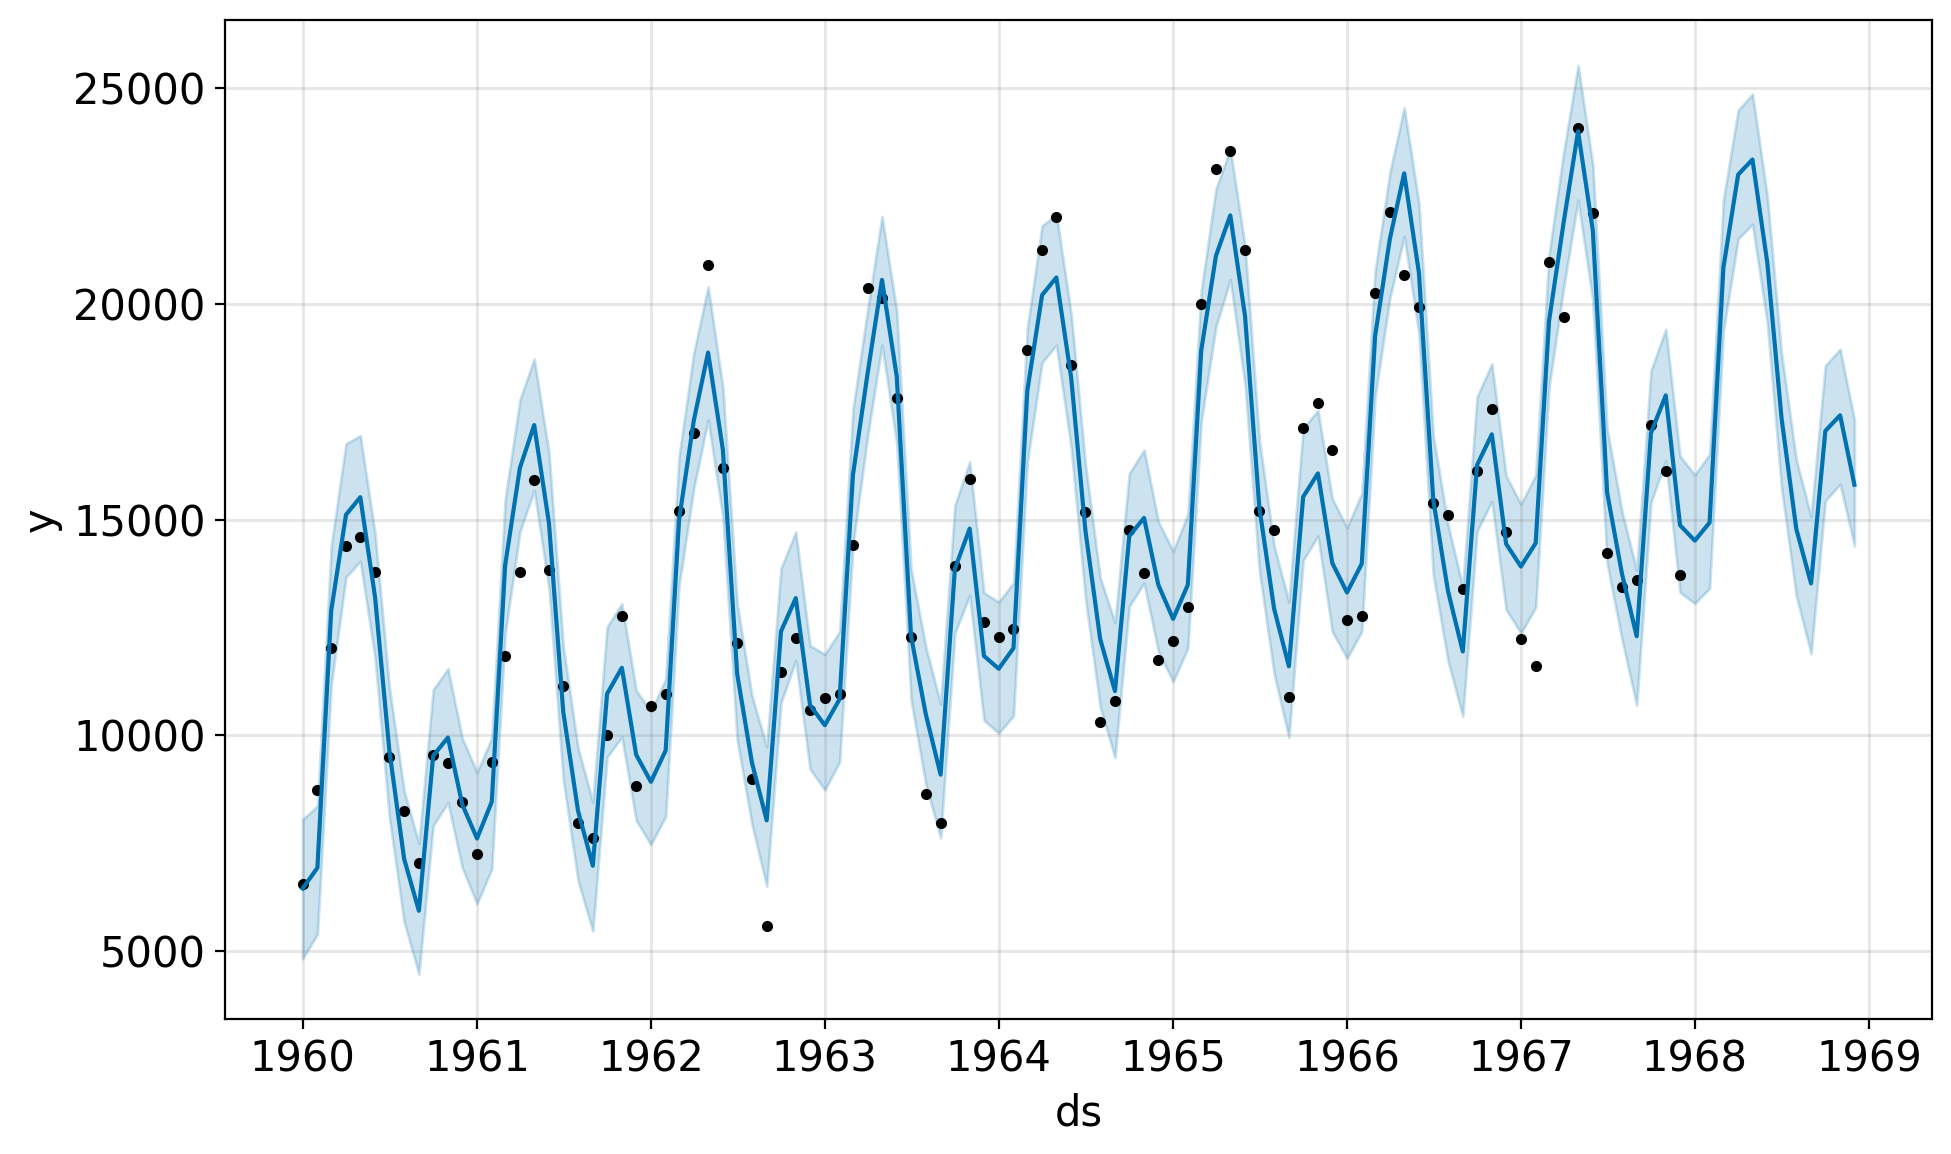

In [46]:
_ = model.plot(forecast)

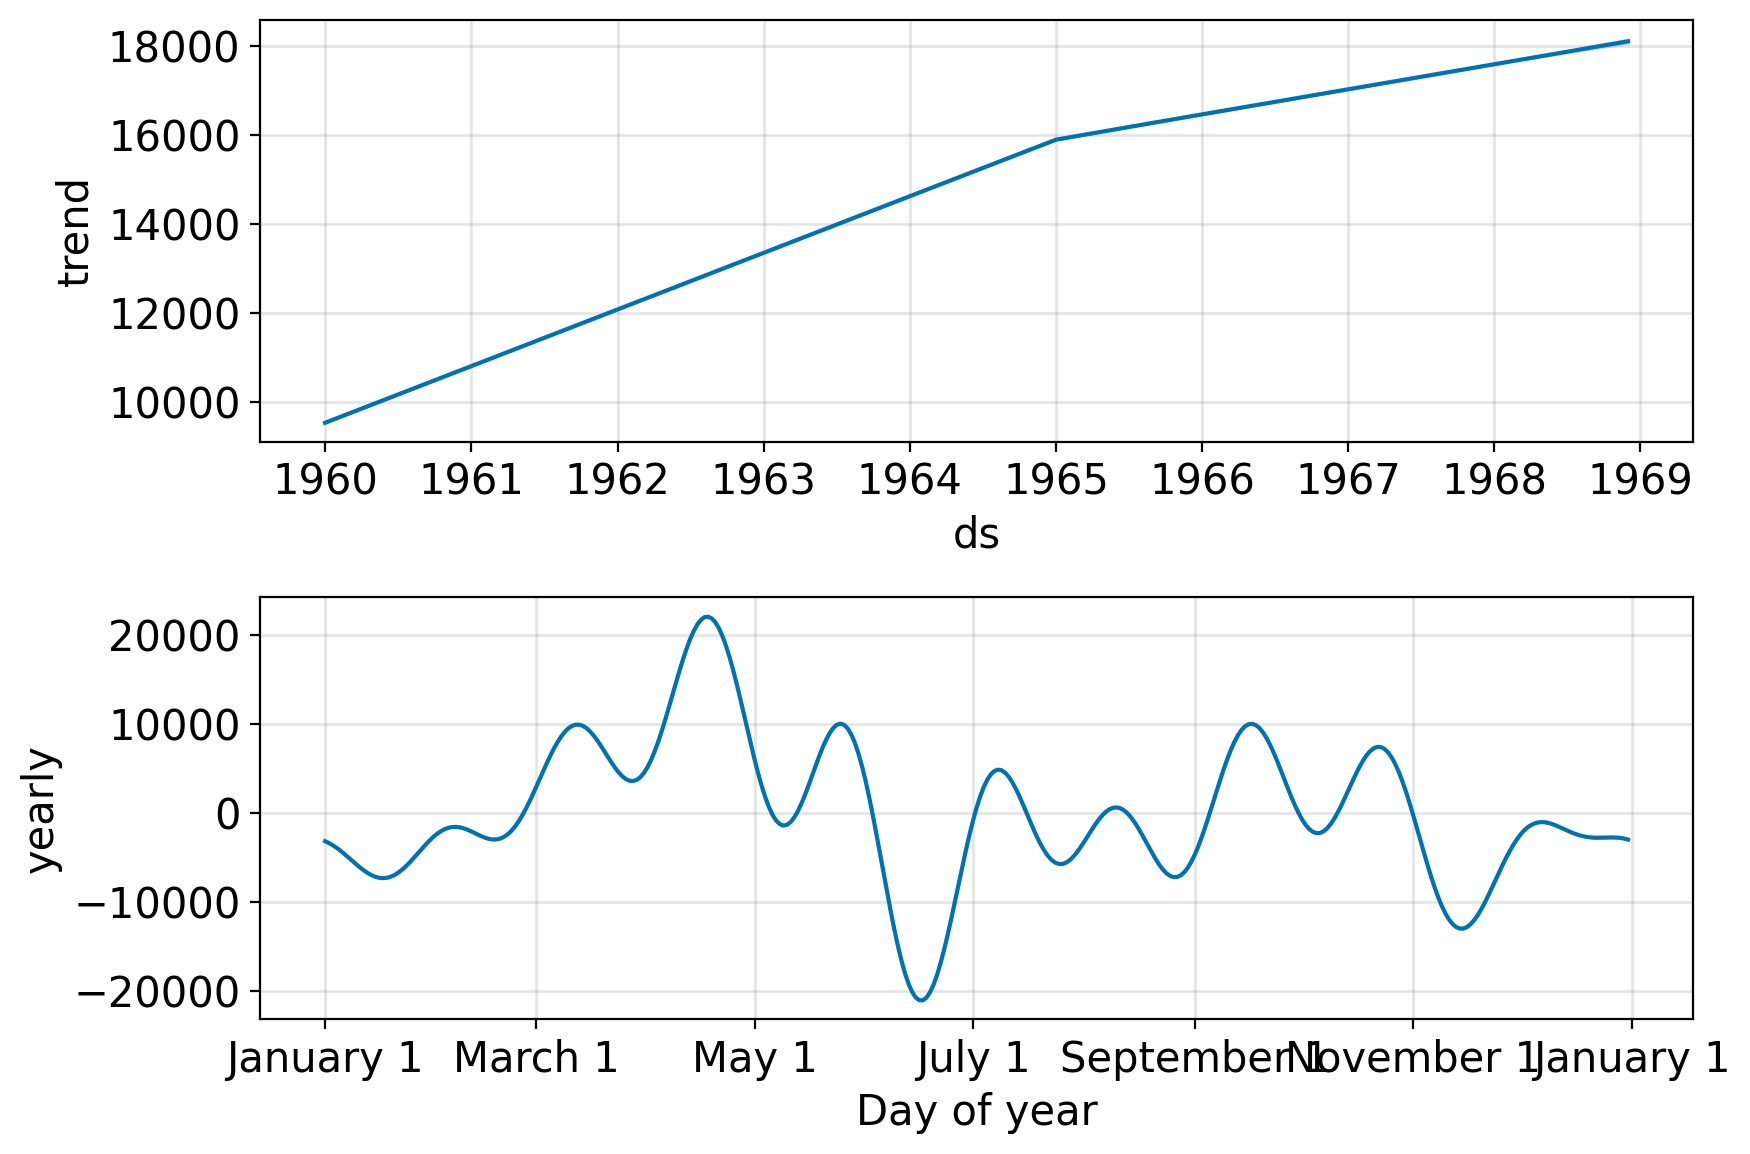

In [47]:
_ = model.plot_components(forecast)

In [48]:
show_reg_result(y_test,y_pred)  #R-Squared를 반드시 믿지는 마시옴.

Max Error:  4283.935
Mean Absolute Error:  1336.813
Root Mean Squared Error:  1749.184
R-Squared:  0.782


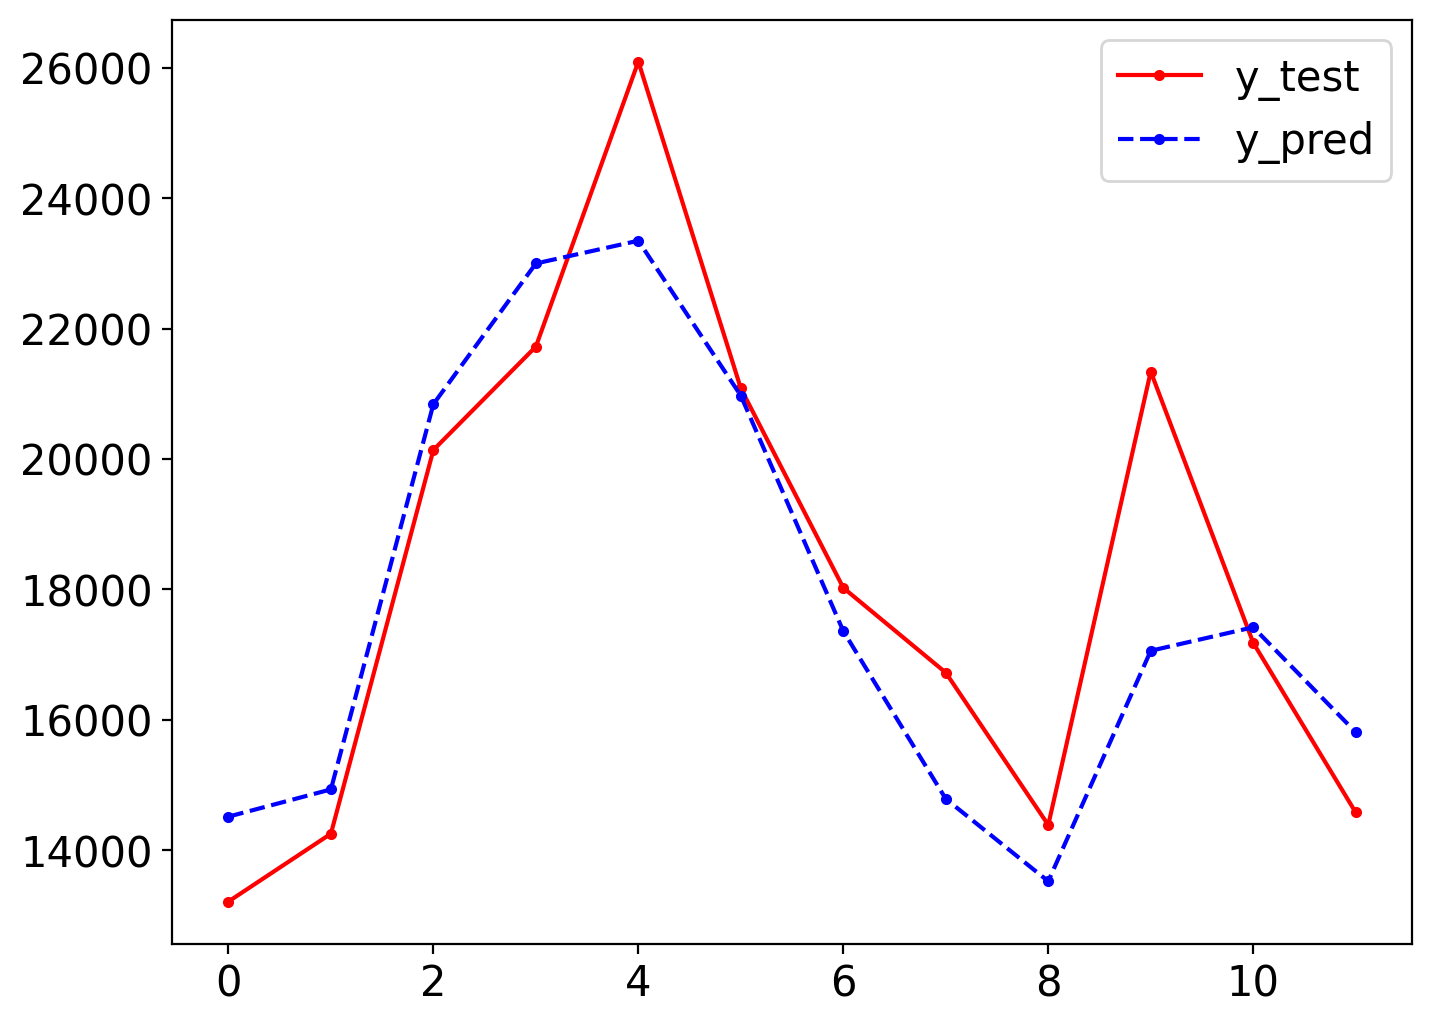

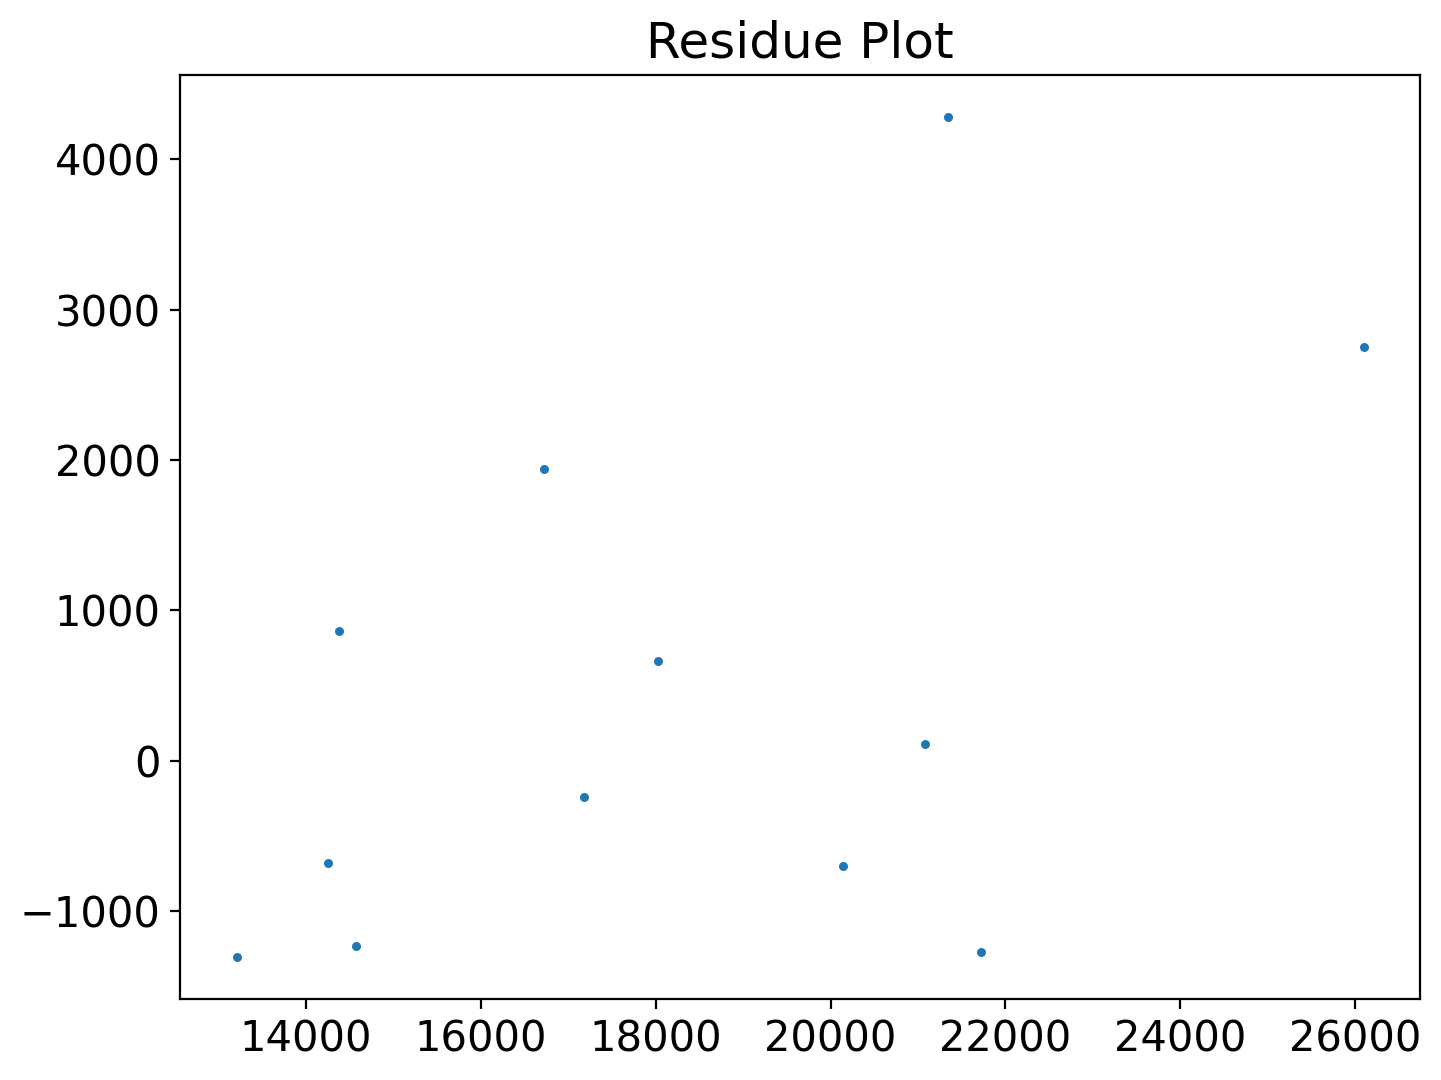

In [49]:
plot_reg_result(y_test,y_pred)

## (연습) 자동차 판매 데이터에서 최근 2년치를 예측하는 모델을 만드시오

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp98tnp7n7/hp_3tm4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp98tnp7n7/8yzv7gah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78675', 'data', 'file=/tmp/tmp98tnp7n7/hp_3tm4a.json', 'init=/tmp/tmp98tnp7n7/8yzv7gah.json', 'output', 'file=/tmp/tmp98tnp7n7/prophet_modelni9zvgsk/prophet_model-20230921011525.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:15:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


(108, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      108 non-null    datetime64[ns]
 1   y       108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


01:15:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


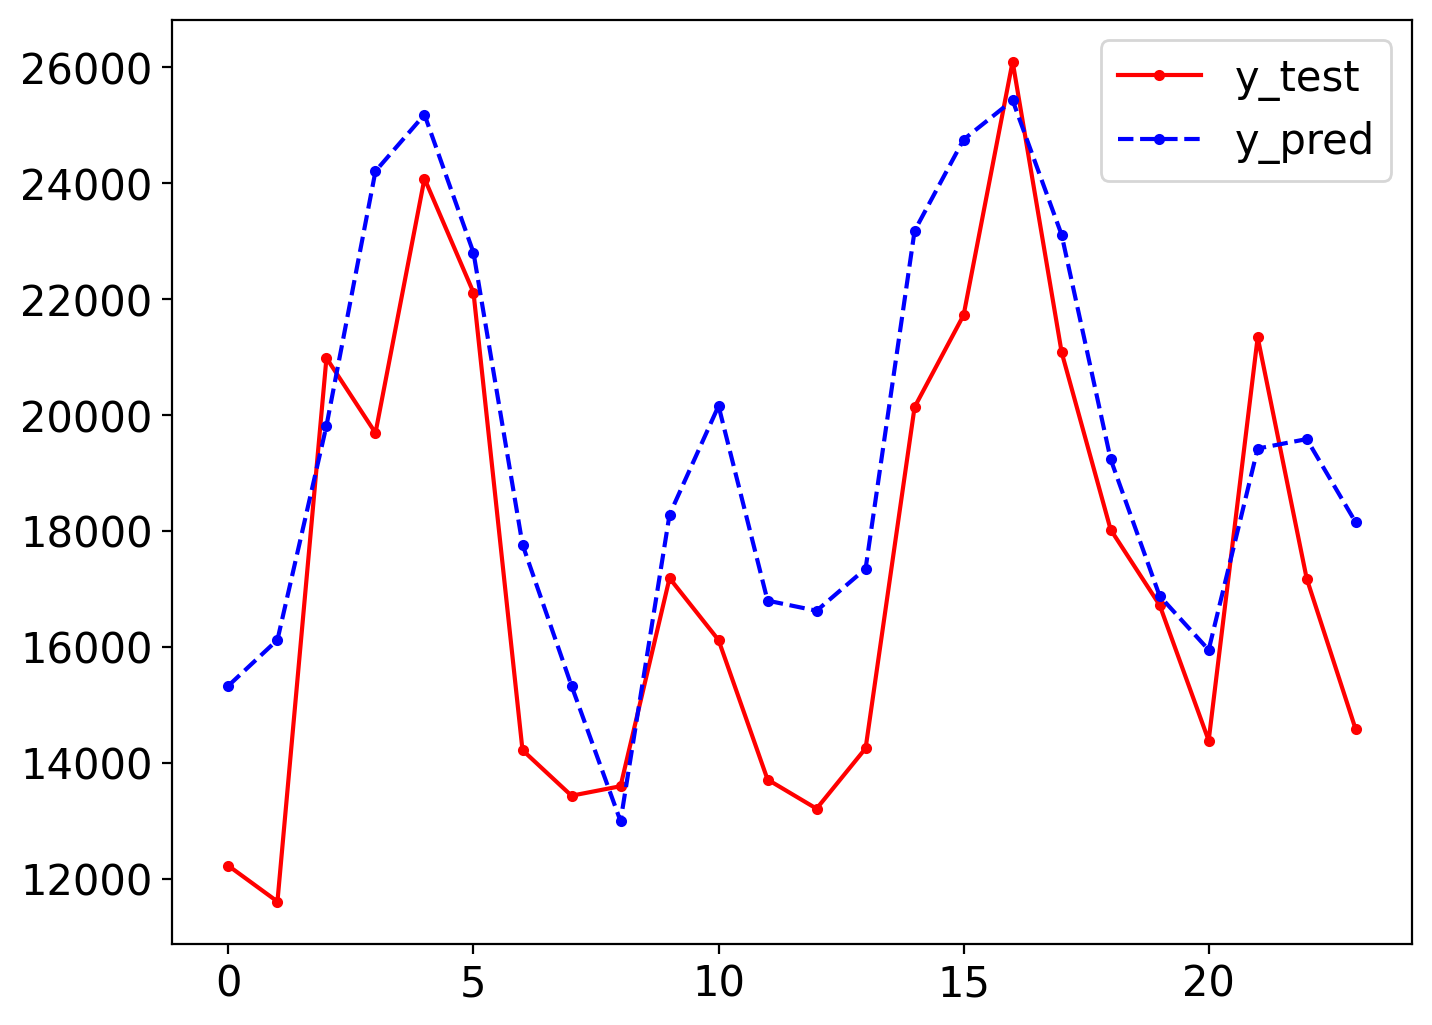

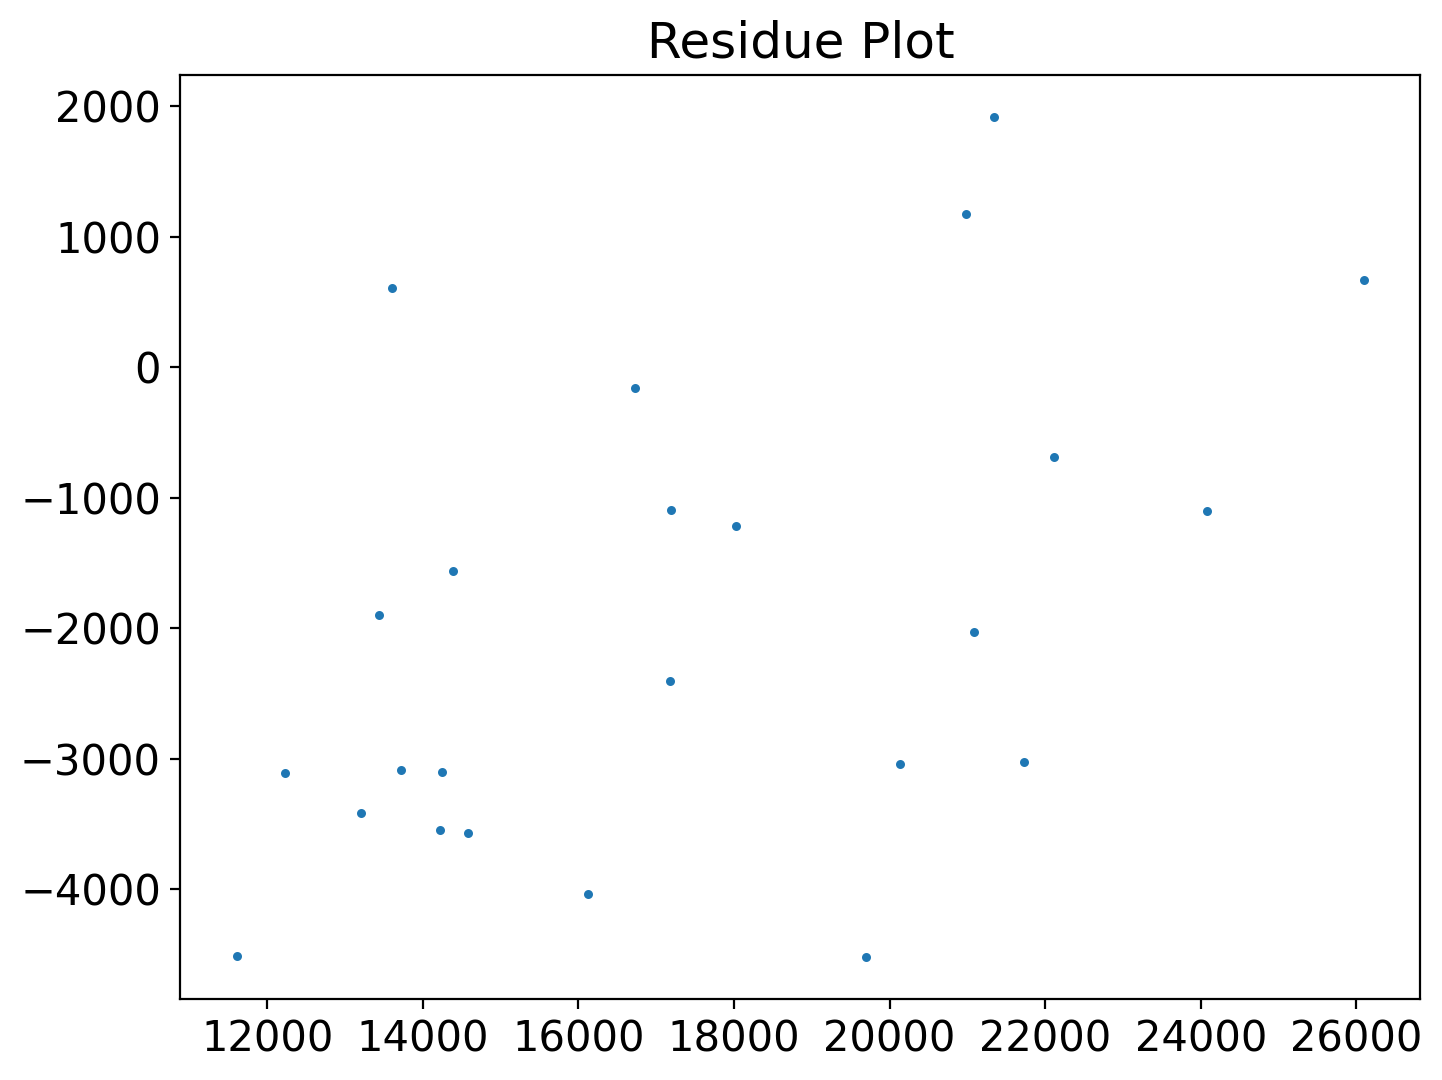

In [54]:
# (풀이)

path = 'https://raw.githubusercontent.com/StillWork/data/master/car_sales.csv'
car = pd.read_csv(path)
print(car.shape)
car[:3]
car.columns = ['ds', 'y']
car['ds']= pd.to_datetime(car['ds'])
car.info()
df = car.copy()
train_data = df[:-24]
test_data = df[-24:]

all_range = df.drop("y", axis=1)
all_range

model = Prophet()
model.fit(train_data)
forecast = model.predict(all_range)
y_pred = forecast[-24:]['yhat'].values
y_test = test_data['y'].values

#_ = model.plot(forecast)  # _ 는 그래프만 보고 싶을때 씀. 없으면 글자가 막막 나타남.
#_ = model.plot_components(forecast)
#show_reg_result(y_test,y_pred)    # R-Squared  : 0.556
plot_reg_result(y_test,y_pred)   #

# 정답

## (연습) 훈련 데이터로 950개를 사용하는 모델을 만드시오

In [ ]:
df = power.resample('D').sum()
df.reset_index(inplace=True)
df.drop('temp', axis=1, inplace=True)
df.columns = ['ds','y']
cut = 950
train_data = df[:cut]
test_data = df[cut:]
m = Prophet()
m.fit(train_data)
all_range = df.copy()
all_range.drop('y', axis=1, inplace=True)
forecast = m.predict(all_range)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
y_test = test_data.y
y_pred = forecast[cut:].yhat
show_reg_result(y_test,y_pred)

Max Error:  16154.277
Mean Absolute Error:  5263.559
Root Mean Squared Error:  6046.279
R-Squared:  -0.212


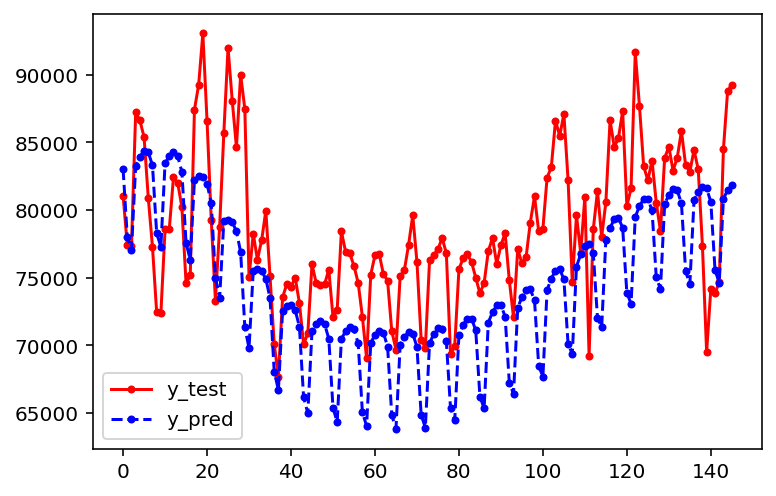

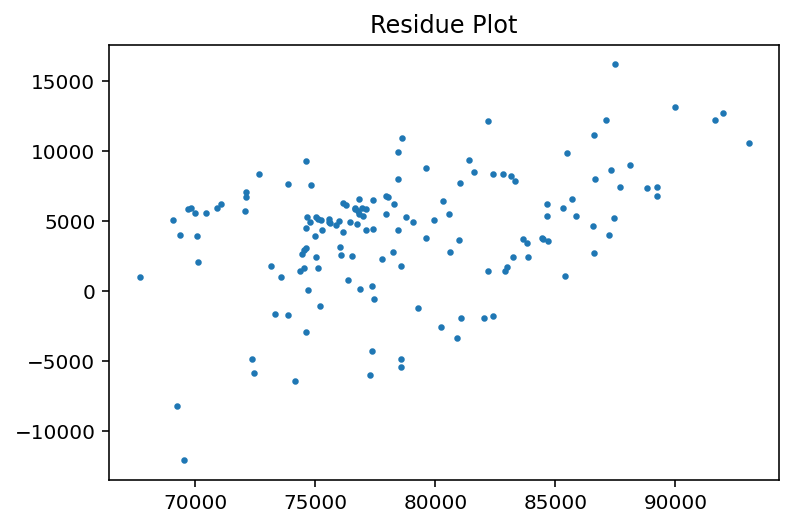

In [ ]:
plot_reg_result(y_test,y_pred,500)

## (연습) 자동차 판매 데이터에서 최근 2년치를 예측하는 모델을 만드시오

In [ ]:
df = car.copy()
train_data = df[:-24]
test_data = df[-24:]
all_range = df.drop("y", axis=1)
model = Prophet()
model.fit(train_data)

forecast = model.predict(all_range)
y_pred = forecast[-24:]['yhat'].values
y_test = test_data['y'].values


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


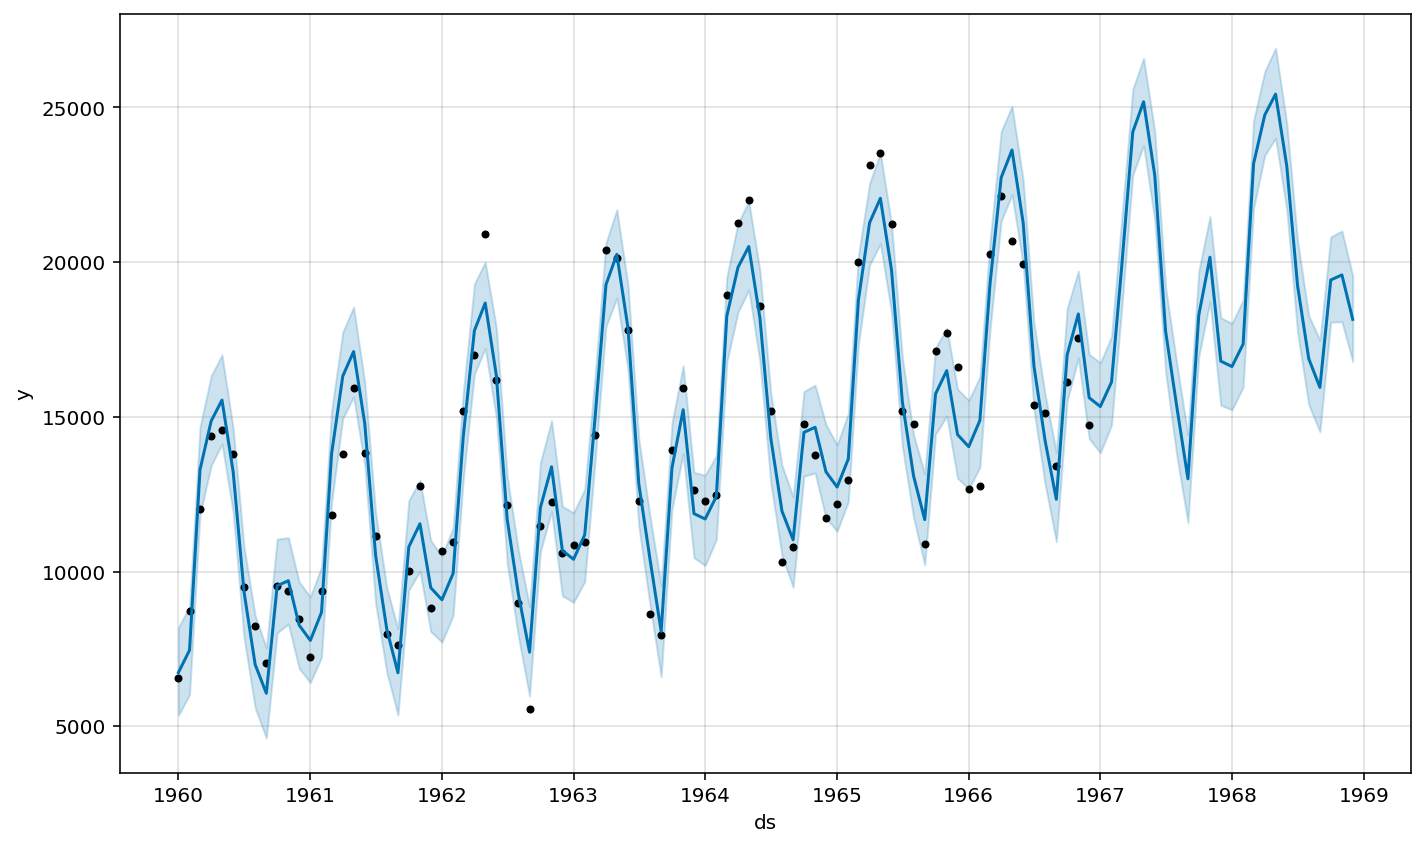

In [ ]:
_ = model.plot(forecast)

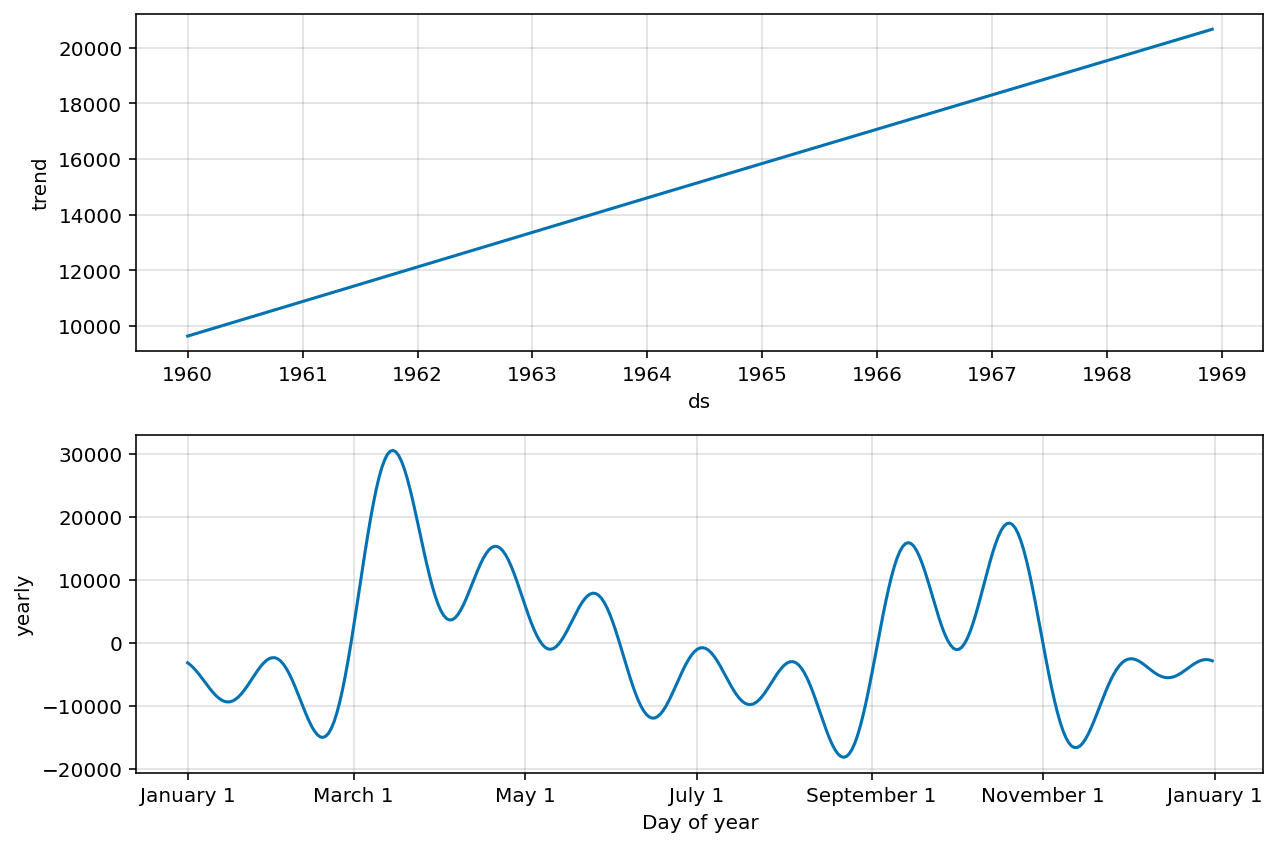

In [ ]:
_ = model.plot_components(forecast)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  4515.65
Mean Absolute Error:  2311.457
Root Mean Squared Error:  2641.612
R-Squared:  0.556


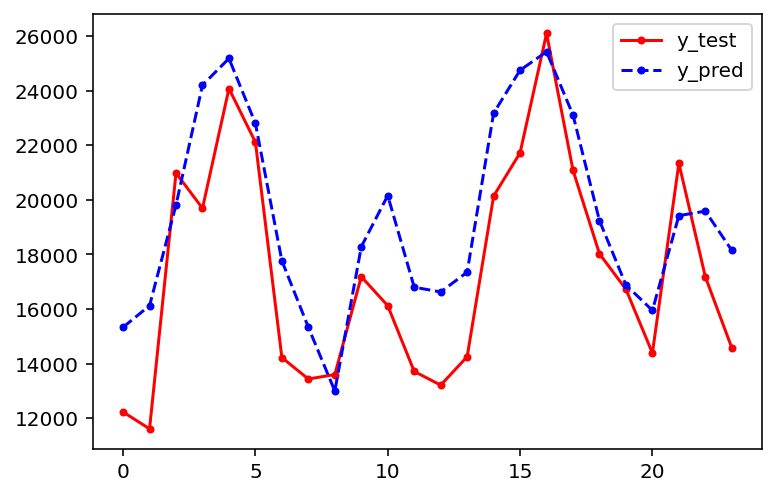

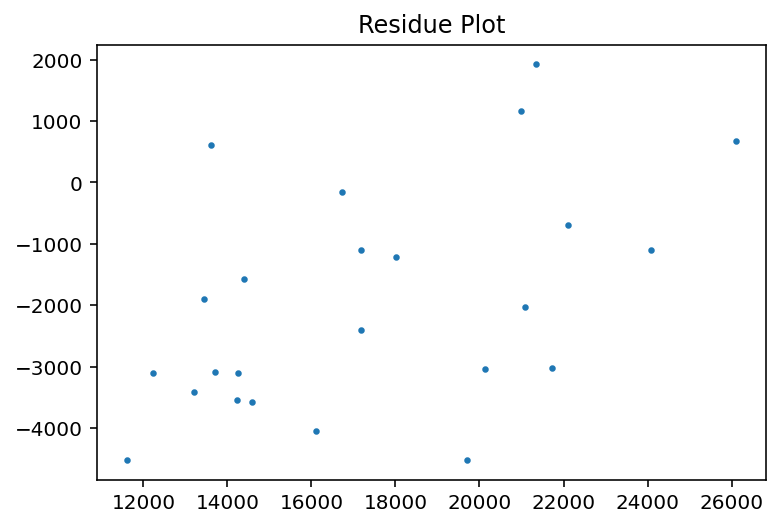

In [ ]:
plot_reg_result(y_test, y_pred, N=100)